## pip Install

In [1]:
INTERNET = True

if INTERNET == True:
    !python --version

    !pip install monai
    !pip install -q segmentation_models_pytorch
    !pip install warmup-scheduler

Python 3.7.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2983 sha256=5ce4d16fd3e5b7b7911a56ba185d118be172bab430c7bdaacb229194af0b5d97
  Stored in directory: /root/.cache/pip/wheels/66/42/8a/00cdef6e5a066e48a92c24051fdcdd57d87faa24c9b5f44a02
Successfully built warmup-scheduler


## Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import cv2
import re
import gc
from tqdm import tqdm
from pprint import pprint
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import skimage.transform as skTrans
from skimage import exposure

import albumentations as alb
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
from torch.optim.lr_scheduler import OneCycleLR

import tensorflow as tf

from monai.transforms import Resize
import monai.transforms as transforms

import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

## Config

In [3]:
SEED = 1927550
IMG_SIZE = 512
BATCH = 8
EPOCH = 5
CLASS = 9 # from 0 to 8
WORK = 'kaggle'
encoder_backbone = 'timm-efficientnet-b5'
best_acc = 0
best_loss = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
folds = 5

trainlosslog = []
trainacclog = []
trainpreclog = []
validlosslog = []
validacclog = []
validpreclog = []

seg_revert = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

## Preprocessing

In [4]:
base_path = '/kaggle/input'
vert_df = pd.read_csv(f'{base_path}/sagittal-preprocess/vert_list.csv')
vert_df['StudyInstanceUID'] = 0

for idx in range(len(vert_df)):
    vert_id = vert_df.loc[idx]['id']
    studyuid = vert_id.split('_')[0]
    vert_df['StudyInstanceUID'][idx] = studyuid

In [5]:
vert_df

id  vertebrae           StudyInstanceUID
0         1.2.826.0.1.3680043.1363_0       10.0   1.2.826.0.1.3680043.1363
1         1.2.826.0.1.3680043.1363_1       10.0   1.2.826.0.1.3680043.1363
2         1.2.826.0.1.3680043.1363_2       10.0   1.2.826.0.1.3680043.1363
3         1.2.826.0.1.3680043.1363_3       10.0   1.2.826.0.1.3680043.1363
4         1.2.826.0.1.3680043.1363_4       10.0   1.2.826.0.1.3680043.1363
...                              ...        ...                        ...
29827  1.2.826.0.1.3680043.26990_237        0.0  1.2.826.0.1.3680043.26990
29828  1.2.826.0.1.3680043.26990_238        0.0  1.2.826.0.1.3680043.26990
29829  1.2.826.0.1.3680043.26990_239        0.0  1.2.826.0.1.3680043.26990
29830  1.2.826.0.1.3680043.26990_240        0.0  1.2.826.0.1.3680043.26990
29831  1.2.826.0.1.3680043.26990_241        0.0  1.2.826.0.1.3680043.26990

[29832 rows x 3 columns]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 4. 5.]
(512, 512)


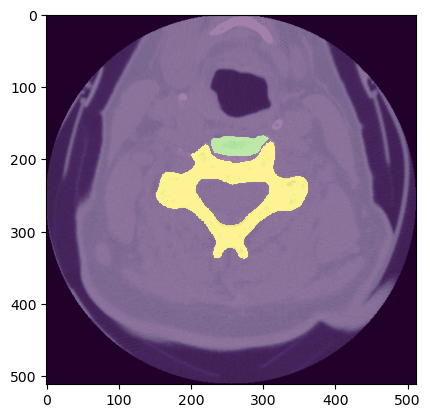

In [6]:
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
from glob import glob

# testing for axial viewed image with labels
base_path = '/kaggle/input'
uid_id = '1.2.826.0.1.3680043.32071'
id = 150

if uid_id in seg_revert:
    length = len(glob(f'/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/{uid_id}/*'))
    length = length - id - 1
    new_uid_id = f'{uid_id}_{length}'

img = np.load(f'{base_path}/3-channel-preprocessed-dataset/prep_train/{new_uid_id}.npz')['arr_0']
mask = nib.load(f'{base_path}/rsna-2022-cervical-spine-fracture-detection/segmentations/{uid_id}.nii')
mask = mask.get_fdata()
mask = mask[:, ::-1, ::-1].transpose(2, 1, 0)[id]
print(mask)
print(np.unique(mask))
print(mask.shape)

plt.imshow(img[:,:,0], cmap='bone')
plt.imshow(mask, interpolation='nearest', alpha=0.5)
plt.show()

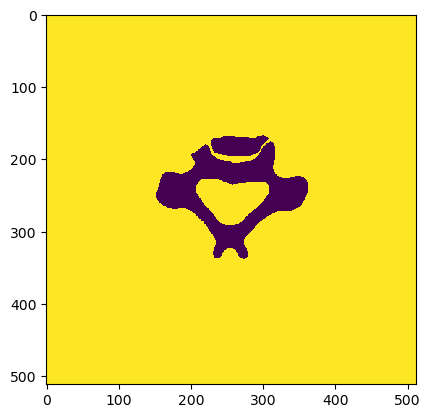

In [7]:
mask = np.where(mask==0, 1, 0)
plt.imshow(mask, interpolation='nearest')
plt.show()

## Drop Bad Scans

https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/344862

1. 1.2.826.0.1.3680043.20574: does not include a full cervical spine and should be ignored.
1. 1.2.826.0.1.3680043.29952: the slices are duplicated, meaning that there are 2 scans stiched to each other.

In [8]:
bad_scans = ['1.2.826.0.1.3680043.20574','1.2.826.0.1.3680043.29952']

for uid in bad_scans:
    vert_df.drop(vert_df[vert_df['StudyInstanceUID']==uid].index, axis=0, inplace=True)

vert_df.reset_index(drop=True)

id  vertebrae           StudyInstanceUID
0         1.2.826.0.1.3680043.1363_0       10.0   1.2.826.0.1.3680043.1363
1         1.2.826.0.1.3680043.1363_1       10.0   1.2.826.0.1.3680043.1363
2         1.2.826.0.1.3680043.1363_2       10.0   1.2.826.0.1.3680043.1363
3         1.2.826.0.1.3680043.1363_3       10.0   1.2.826.0.1.3680043.1363
4         1.2.826.0.1.3680043.1363_4       10.0   1.2.826.0.1.3680043.1363
...                              ...        ...                        ...
29827  1.2.826.0.1.3680043.26990_237        0.0  1.2.826.0.1.3680043.26990
29828  1.2.826.0.1.3680043.26990_238        0.0  1.2.826.0.1.3680043.26990
29829  1.2.826.0.1.3680043.26990_239        0.0  1.2.826.0.1.3680043.26990
29830  1.2.826.0.1.3680043.26990_240        0.0  1.2.826.0.1.3680043.26990
29831  1.2.826.0.1.3680043.26990_241        0.0  1.2.826.0.1.3680043.26990

[29832 rows x 3 columns]

## Useful Functions

In [9]:
# apply seed
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [10]:
def dataloader_creator(df_train, df_valid):
    train_dataset = CustomDataset(df=df_train, transform=data_transforms['train'], test=False)
    valid_dataset = CustomDataset(df=df_valid, transform=data_transforms['valid'], test=False)
    train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH, shuffle=True)
    
    return train_loader, valid_loader

In [11]:
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

## Image Transform

In [12]:
data_transforms = {
    'train': alb.Compose([
                alb.HorizontalFlip(p=0.5),
                alb.VerticalFlip(p=0.5),
                alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
                alb.OneOf([
                    alb.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                    alb.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                    alb.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
                ], p=0.25),
                alb.CoarseDropout(max_holes=8, max_height=IMG_SIZE//20, max_width=IMG_SIZE//20, min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
             ]),
    'valid': alb.Compose([])
}

## Dataset

reverted segmentation

https://www.kaggle.com/code/itsuki9180/a-segmentation-is-in-reverse-order

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df=vert_df, transform=None, test=False):
        super().__init__()
        self.df        = df
        self.transform = transform
        self.test      = test
    
    
    def __getitem__(self, idx):
        UID = self.df.iloc[idx]
        uid_id = UID['id'] # 1.2.826.0.1.3680043.{studyuid}_{id}
        studyuid = UID['StudyInstanceUID']
        
        new_uid_id = uid_id
        if studyuid in seg_revert:
            length = len(glob(f'/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/{studyuid}/*'))
            length = length - int(uid_id.split('_')[1]) - 1
            new_uid_id = f'{studyuid}_{length}'
        
        image = np.load(f'{base_path}/3-channel-preprocessed-dataset/prep_train/{new_uid_id}.npz')['arr_0'] # 512 x 512 x 3

        if self.test == True:
            if self.transform is not None:
                trans = self.transform(image=image)
                image = trans['image']
                image = np.transpose(image, (2, 0, 1))
            return UID['id'], torch.from_numpy(np.array(image/255.0, dtype=np.float32)).float()
        
        mask_path = f'{base_path}/preprocess-3-channel/{uid_id}.npz' # 512 x 512
        mask = np.load(mask_path)['arr_0'] # already rotated to sagittal view
        
        if self.transform is not None:
            trans = self.transform(image=image, mask=mask)
            image = trans['image']
            mask = trans['mask']
        
        # image alignment: (channel, width, height)
        image = np.transpose(image, (2, 0, 1))
        
        real_mask = []
        # change all vertebraes from T1-T12 to be located in channel 9
        mask = np.where(mask > 8, 8, mask)
        
        # extract which class this image is located,
        # and place the image at that channel
        # fill other channels with zeros
        for channel in range(CLASS):
            if channel in list(np.unique(mask)): real_mask.append(np.where(mask==channel, 1, 0))
            else: real_mask.append(np.zeros((IMG_SIZE, IMG_SIZE)))
        
        # https://github.com/qubvel/segmentation_models/issues/403
        train, seg = torch.from_numpy(np.array(image/255.0, dtype=np.float32)).float(), torch.from_numpy(np.array(real_mask, dtype=np.float32)).float()
        del(real_mask)
        return train, seg
    
    
    def __len__(self):
        return self.df.shape[0]

## Model

In [14]:
# important to have a bigger backbone
# EfficientNet-B5 backbone + UNet decoder
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.segmodel = smp.Unet(              # cnn
            encoder_backbone,                  # efficientnet-b5 backbone
            encoder_weights='imagenet',        # pretrained-weight = imagenet
            in_channels=3,                     # in channels of 3
            classes=CLASS,                     # output channel be 7 from C1 to C7
            activation=None,
        )
        
    def forward(self, x):
        return self.segmodel(x)

## Loss Function

In [15]:
def bce_logits(y_pred, y_true):
    loss = smp.losses.SoftBCEWithLogitsLoss()
    return loss(y_pred, y_true)

In [16]:
def iou_coef(y_pred, y_true):
    jaccard = smp.losses.JaccardLoss(mode='multilabel')
    return jaccard(y_pred, y_true)

In [17]:
def criterion(y_pred, y_true):
    return bce_logits(y_pred, y_true)*0.5 + iou_coef(y_pred, y_true)*0.5

In [18]:
def dice_coef(mask1, mask2, epsilon=1e-7):
    mask1 = mask1.detach().cpu().numpy()
    mask2 = mask2.detach().cpu().numpy()
    mask1 = np.where(mask2>0.5, 1, 0)
    
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect + epsilon) / (fsum + ssum + epsilon)
    dice = np.mean(dice)
    
    return dice

## Settings

In [19]:
# model setting
model = SegmentationModel()
model.to(device)

# optimizer, scheduler setting
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH-1, eta_min=1e-6, last_epoch=-1)
scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

## Train and Validation Functions

In [20]:
def train(model, dataloader, optimizer):
    model.train()
    scaler = GradScaler()
    scheduler = OneCycleLR(optimizer, max_lr=0.001, epochs=1, steps_per_epoch=len(df_train), pct_start=0.3)
    
    train_loss = []
    train_acc = []
    train_prec = []
    
    for idx, (imgs, masks) in enumerate(tqdm(dataloader)):
        # set the gradient to 0 at initial
        optimizer.zero_grad()

        # forward data, making sure the data and model are on the same device
        with autocast(enabled=True):
            logits = model(imgs.to(device))
            loss = criterion(logits, masks.to(device))
        
        logits = logits.sigmoid()
        acc = ((logits>0.5) == masks.to(device)).float().mean()
        prec = dice_coef(logits, masks.to(device))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss.append(loss.item())
        train_acc.append(acc)
        train_prec.append(prec)
    
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_acc) / len(train_acc)
    train_prec = sum(train_prec) / len(train_prec)
    
    return train_loss, train_acc, train_prec

In [21]:
def validation(model, dataloader, optimizer):
    model.eval()
    
    valid_loss = []
    valid_acc = []
    valid_prec = []
    
    for imgs, masks in tqdm(dataloader):
        # no need gradient in validation
        # use torch.no_grad() accelerates the forward process
        with torch.no_grad():
            logits = model(imgs.to(device))

        loss = criterion(logits, masks.to(device))
        
        logits = logits.sigmoid()
        acc = ((logits>0.5) == masks.to(device)).float().mean()
        prec = dice_coef(logits, masks.to(device))#.detach().cpu().numpy()
        
        valid_loss.append(loss.item())
        valid_acc.append(acc)
        valid_prec.append(prec)
    
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_acc) / len(valid_acc)
    valid_prec = sum(valid_prec) / len(valid_prec)
    
    return valid_loss, valid_acc, valid_prec

## Train

In [22]:
seg_df = pd.read_csv(f'{base_path}/3-channel-preprocessed-dataset/train_df.csv')
df = vert_df[np.isin(vert_df['StudyInstanceUID'], seg_df['StudyInstanceUID'])].reset_index(drop=True)

In [23]:
df

id  vertebrae           StudyInstanceUID
0         1.2.826.0.1.3680043.1363_0       10.0   1.2.826.0.1.3680043.1363
1         1.2.826.0.1.3680043.1363_1       10.0   1.2.826.0.1.3680043.1363
2         1.2.826.0.1.3680043.1363_2       10.0   1.2.826.0.1.3680043.1363
3         1.2.826.0.1.3680043.1363_3       10.0   1.2.826.0.1.3680043.1363
4         1.2.826.0.1.3680043.1363_4       10.0   1.2.826.0.1.3680043.1363
...                              ...        ...                        ...
29827  1.2.826.0.1.3680043.26990_237        0.0  1.2.826.0.1.3680043.26990
29828  1.2.826.0.1.3680043.26990_238        0.0  1.2.826.0.1.3680043.26990
29829  1.2.826.0.1.3680043.26990_239        0.0  1.2.826.0.1.3680043.26990
29830  1.2.826.0.1.3680043.26990_240        0.0  1.2.826.0.1.3680043.26990
29831  1.2.826.0.1.3680043.26990_241        0.0  1.2.826.0.1.3680043.26990

[29832 rows x 3 columns]

In [24]:
kf = KFold(folds)
for fold_idx, (t_idx, val_idx) in enumerate(kf.split(df, df)):
    df.loc[val_idx, 'sub_fold'] = fold_idx

df_train = df[df['sub_fold'] != fold_idx].reset_index(drop=True)
df_valid = df[df['sub_fold'] == fold_idx].reset_index(drop=True)
train_loader, valid_loader = dataloader_creator(df_train, df_valid)

In [25]:
seed_everything(SEED)

# initialize the best values to save
best_train_loss = 0
best_train_acc = 0
best_train_prec = 0
best_valid_loss = 0
best_valid_acc = 0
best_valid_prec = 0

best_epoch = 0
early_stop_count = 0

# start training
for epoch in range(EPOCH):
    print(f'### Epoch: {epoch+1} ###')
    train_loss, train_acc, train_prec = train(model, train_loader, optimizer)
    print(f'[ Train | {epoch + 1:03d}/{EPOCH:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, prec = {train_prec:.5f}')
    valid_loss, valid_acc, valid_prec = validation(model, valid_loader, optimizer)
    print(f'[ Valid | {epoch + 1:03d}/{EPOCH:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, prec = {valid_prec:.5f}')
    print()

    scheduler_warmup.step()
    
    # save train and valid logs
    trainlosslog.append(train_loss)
    trainacclog.append(train_acc.cpu().data.numpy())
    trainpreclog.append(train_prec)
    validlosslog.append(valid_loss)
    validacclog.append(valid_acc.cpu().data.numpy())
    validpreclog.append(valid_prec)

    # save models
    if valid_loss < best_loss:
        # save highest values
        best_train_loss, best_train_acc, best_train_prec = train_loss, train_acc, train_prec
        best_valid_loss, best_valid_acc, best_valid_prec = valid_loss, valid_acc, valid_prec
        best_epoch = epoch

        # save model
        torch.save(model.state_dict(), "stage1_sagittal_best.ckpt") # only save best to prevent output memory exceed error
        # reset values
        best_loss = valid_loss
        early_stop_count = 0

    if early_stop_count > 5:
        print('Preformance not increasing. Early Stopping...')
        break

    early_stop_count = early_stop_count + 1

print()
print(f"[ Best Train | {best_epoch+1:03d} / {EPOCH:03d} ] loss = {best_train_loss:.5f}, acc = {best_train_acc:.5f}, prec = {best_train_prec:.5f}")
print(f"[ Best Valid | {best_epoch+1:03d} / {EPOCH:03d} ] loss = {best_valid_loss:.5f}, acc = {best_valid_acc:.5f}, prec = {best_valid_prec:.5f}")

### Epoch: 1 ###


100%|██████████| 2984/2984 [1:53:09<00:00,  2.28s/it]


[ Train | 001/005 ] loss = 0.34808, acc = 0.97649, prec = 1.00000


100%|██████████| 746/746 [16:21<00:00,  1.32s/it]


[ Valid | 001/005 ] loss = 0.24565, acc = 0.99275, prec = 1.00000

### Epoch: 2 ###


100%|██████████| 2984/2984 [1:49:05<00:00,  2.19s/it]


[ Train | 002/005 ] loss = 0.20268, acc = 0.99544, prec = 1.00000


100%|██████████| 746/746 [14:09<00:00,  1.14s/it]


[ Valid | 002/005 ] loss = 0.19692, acc = 0.99544, prec = 1.00000

### Epoch: 3 ###


100%|██████████| 2984/2984 [1:45:07<00:00,  2.11s/it]


[ Train | 003/005 ] loss = 0.16734, acc = 0.99694, prec = 1.00000


100%|██████████| 746/746 [14:45<00:00,  1.19s/it]


[ Valid | 003/005 ] loss = 0.18684, acc = 0.99725, prec = 1.00000

### Epoch: 4 ###


100%|██████████| 2984/2984 [1:45:25<00:00,  2.12s/it]


[ Train | 004/005 ] loss = 0.13216, acc = 0.99821, prec = 1.00000


100%|██████████| 746/746 [14:15<00:00,  1.15s/it]


[ Valid | 004/005 ] loss = 0.15030, acc = 0.99771, prec = 1.00000

### Epoch: 5 ###


100%|██████████| 2984/2984 [1:45:58<00:00,  2.13s/it]


[ Train | 005/005 ] loss = 0.11451, acc = 0.99866, prec = 1.00000


100%|██████████| 746/746 [14:17<00:00,  1.15s/it]

[ Valid | 005/005 ] loss = 0.15090, acc = 0.99810, prec = 1.00000


[ Best Train | 004 / 005 ] loss = 0.13216, acc = 0.99821, prec = 1.00000
[ Best Valid | 004 / 005 ] loss = 0.15030, acc = 0.99771, prec = 1.00000


In [26]:
log_df = pd.DataFrame(
    {
        'trainLoss': trainlosslog,
        'trainAcc': trainacclog,
        'trainPrec': trainpreclog,
        'validLoss': validlosslog,
        'validAcc': validacclog,
        'validPrec': validpreclog
    })

log_df.to_csv('Logs.csv')

## Prediction

In [27]:
model = SegmentationModel()
best_model = model.to(device)
best_model.load_state_dict(torch.load('/kaggle/working/stage1_sagittal_best.ckpt'))

df_train = df[df['sub_fold'] != fold_idx].reset_index(drop=True)
df_valid = df[df['sub_fold'] == fold_idx].reset_index(drop=True)
test_dataset = CustomDataset(df=df_valid, transform=data_transforms['valid'], test=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, pin_memory=True)

## Visualization

In [28]:
def show_img(img, mask=None):
    plt.imshow(img[:,:,0], cmap='bone')

    if mask is not None:
        mask = np.argmax(mask, axis=2)
        plt.imshow(mask, alpha=0.5)
    else:
        print('No mask')
        
    plt.axis('off')

In [29]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

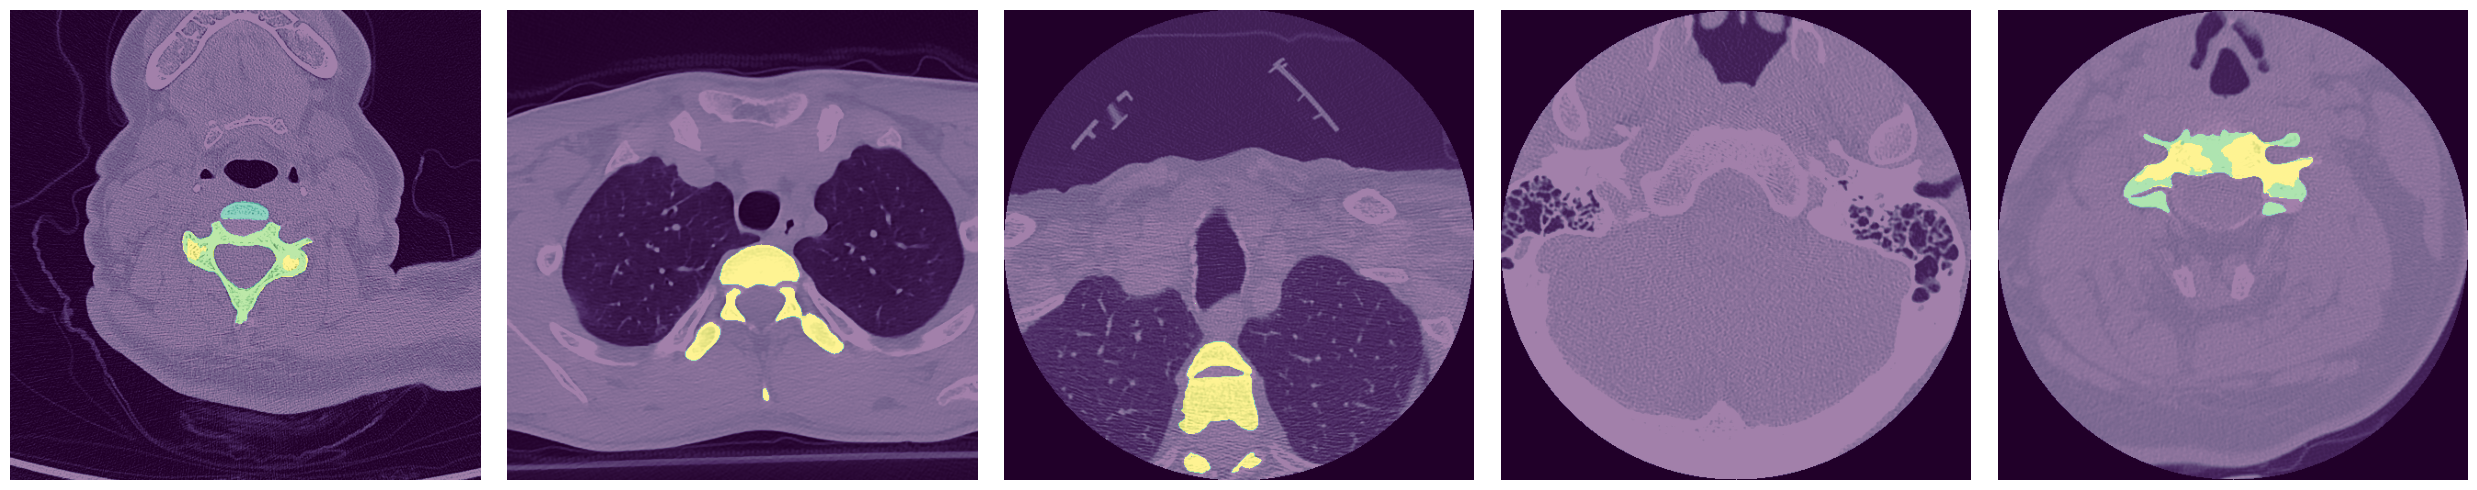

In [30]:
val_imgs, val_real_mask = next(iter(valid_loader))

with torch.no_grad():
    val_msks = best_model(val_imgs.to(device))
    val_msks = (nn.Sigmoid()(val_msks)>0.5).double()
    
plot_batch(val_imgs, val_msks.detach().cpu(), size=5)

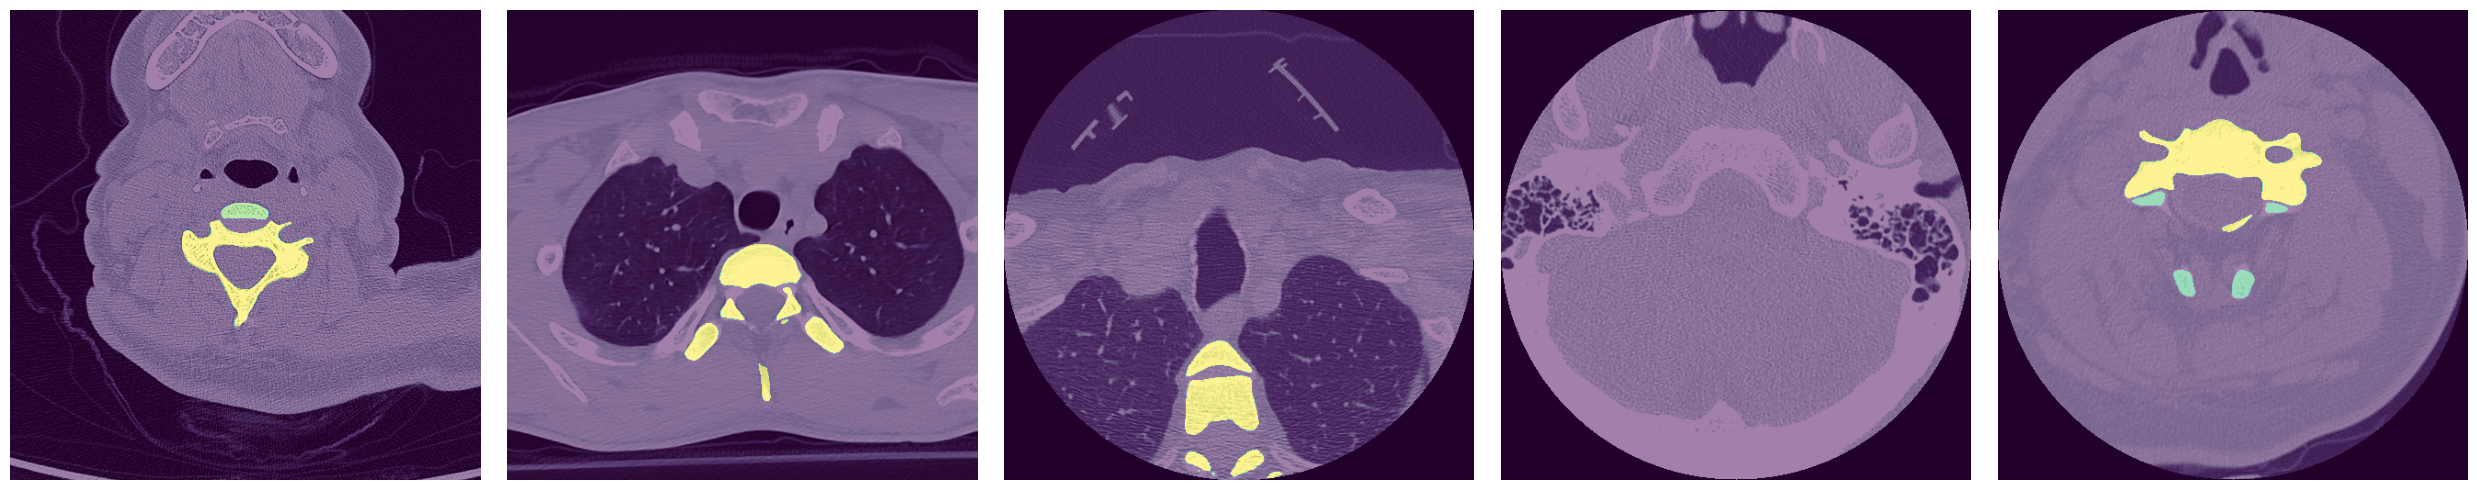

In [31]:
plot_batch(val_imgs, val_real_mask, size=5)

In [32]:
real_mask_channel = []
predict_mask_channel = []

for i in range(5):
    predict_mask_channel.append(np.unique(np.argmax(val_msks.detach().cpu().numpy()[i], axis=0)))
    real_mask_channel.append(np.unique(np.argmax(val_real_mask[i], axis=0)))

print(predict_mask_channel)
print(real_mask_channel)

[array([0, 3, 4, 5]), array([0, 8]), array([0, 8]), array([0]), array([0, 3, 4])]
[array([0, 4, 5]), array([0, 8]), array([0, 8]), array([0]), array([0, 2, 3])]


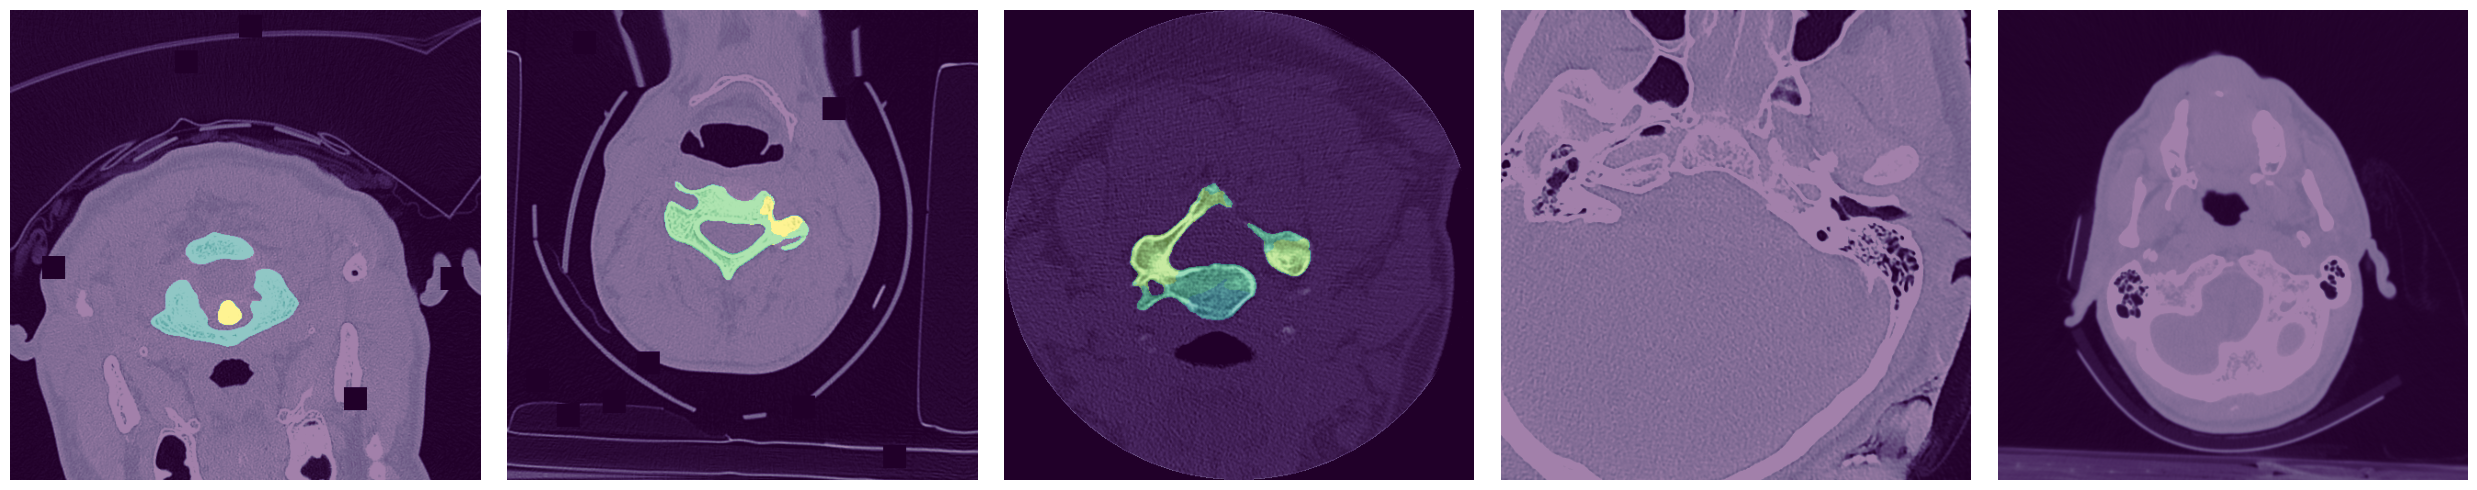

In [33]:
imgs, real_mask = next(iter(train_loader))
with torch.no_grad():
    msks = best_model(imgs.to(device))
    msks = (nn.Sigmoid()(msks)>0.5).double()
    
plot_batch(imgs, msks.detach().cpu(), size=5)

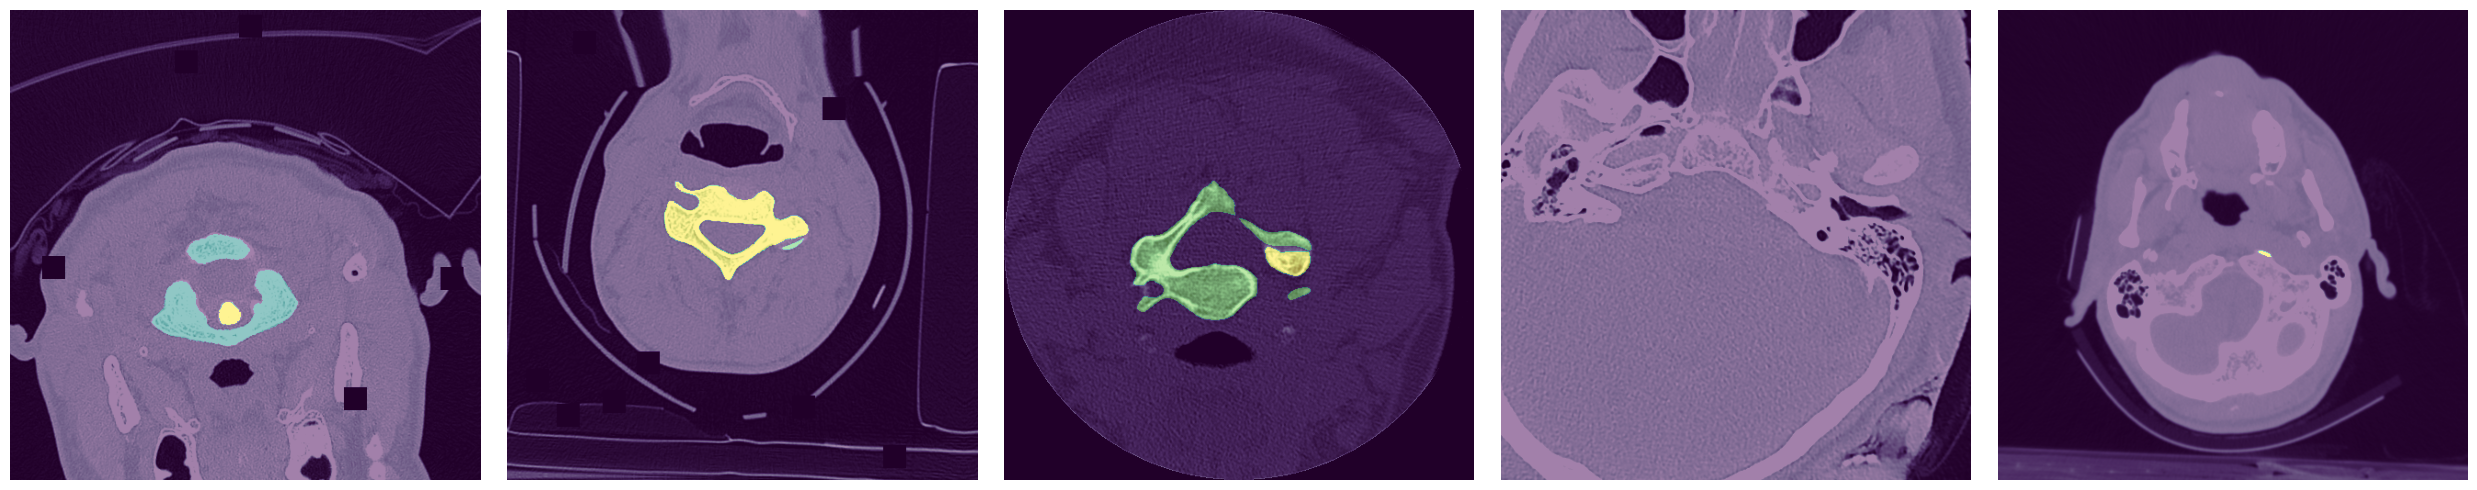

In [34]:
plot_batch(imgs, real_mask, size=5)

In [35]:
train_real_mask_channel = []
train_predict_mask_channel = []

for i in range(5):
    train_predict_mask_channel.append(np.unique(np.argmax(msks.detach().cpu().numpy()[i], axis=0)))
    train_real_mask_channel.append(np.unique(np.argmax(real_mask[i], axis=0)))

print(train_predict_mask_channel)
print(train_real_mask_channel)

[array([0, 1, 2]), array([0, 3, 4]), array([0, 3, 4, 5, 6]), array([0]), array([0])]
[array([0, 1, 2]), array([0, 3, 4]), array([0, 4, 5]), array([0]), array([0, 1])]
